# ELEC474 Lab4

In [409]:
import cv2 as cv
import numpy as np
import random
import math
import time
from matplotlib import pyplot as plt

In [410]:
global my_SIFT_instance, my_BF_instance
my_SIFT_instance = cv.SIFT_create()

FLANN_INDEX_KDTREE = 0 #heard from C++ api that this should be 1
# FLANN_INDEX_KDTREE = 1

img1Name = "cereal.jpg"
img2Name = "cereal_l.jpg"
img3Name = "cereal_r.jpg"
img4Name = "cereal_tl.jpg"
img5Name = "cereal_tr.jpg"

img1 = cv.imread(img1Name)
img2 = cv.imread(img2Name)
img3 = cv.imread(img3Name)
img4 = cv.imread(img4Name)
img5 = cv.imread(img5Name)

imgDescipt_1 = np.array((
"img1 feature points",
"img2 feature points",
"img1, img2 matches"
))

imgDescipt_2 = np.array((
"Reference Image",
"Target Image",
"Color transformed Image"
))


In [411]:
def PltImg(img,imgDescipt):
    plt.figure(dpi=300)
    plt.figure(figsize=(15,15))
    idx = len(img)
    for i in range(idx):
        plt.subplot(1,idx,i+1)

        if(len(img[i].shape) == 2): #differ from gray and color img 
            plt.imshow(img[i],cmap="gray")
        else:
            plt.imshow(cv.cvtColor(img[i], cv.COLOR_BGR2RGB))

        plt.title(imgDescipt[i])
    plt.tight_layout()

In [412]:
def SIFTOut(img, flag): #if flag == 1, then do gray
    imgGray = img
    if flag == 1:
        imgGray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        
    imgKpOut = np.copy(imgGray)
    kp, des = my_SIFT_instance.detectAndCompute(imgGray,None)
    imgKpOut = cv.drawKeypoints(imgKpOut,kp,0)
    return (imgKpOut,kp,des)

def FlannBasedMatchLoweRatio(img1Param,img2Param,
                            index_param,search_param,
                            kNum, ratio):
    flann = cv.FlannBasedMatcher(index_param,search_param)
    matches = flann.knnMatch(img1Param[2],img2Param[2],k = kNum)

    loweMatch = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            loweMatch.append([m])

    imgOut = cv.drawMatchesKnn(img1Param[0],img1Param[1],img2Param[0],img2Param[1],loweMatch,None,flags=2)
    return imgOut, loweMatch

In [413]:
def Matching(img1, img2, flag):
    outImages = []
    keyPoints = []
    descriptors = []
    img1Param = SIFTOut(img1, flag)
    img2Param = SIFTOut(img2, flag)

    #FLANN param 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)       #or pass empty dict #It specifies the number of times the trees in the index should be recursively traversed.
    # search_params = dict(checks = 100)
    flannOut = FlannBasedMatchLoweRatio(img1Param, img2Param,
                            index_params, search_params,
                            kNum = 2, ratio = 0.7)

    #classify params 
    outImages.append(img1Param[0])
    outImages.append(img2Param[0])
    outImages.append(flannOut[0])

    keyPoints.append(img1Param[1])
    keyPoints.append(img2Param[1])

    descriptors.append(img1Param[2])
    descriptors.append(img2Param[2])
    #Plt to check
    PltImg(outImages, imgDescipt_1)

    return keyPoints,descriptors,flannOut[1]

([[<KeyPoint 0000018C6CBE7540>,
   <KeyPoint 0000018C6B603390>,
   <KeyPoint 0000018C531B8D20>,
   <KeyPoint 0000018C383EA150>,
   <KeyPoint 0000018C6B2C8CC0>,
   <KeyPoint 0000018C3B7AB780>,
   <KeyPoint 0000018C3C360600>,
   <KeyPoint 0000018C3C360960>,
   <KeyPoint 0000018C3C80E690>,
   <KeyPoint 0000018C3C80E990>,
   <KeyPoint 0000018C5B09AE40>,
   <KeyPoint 0000018C6B90B1B0>,
   <KeyPoint 0000018C6B90B180>,
   <KeyPoint 0000018C6B90B150>,
   <KeyPoint 0000018C6B90B870>,
   <KeyPoint 0000018C6B90B8A0>,
   <KeyPoint 0000018C68EA7960>,
   <KeyPoint 0000018C68EA7A80>,
   <KeyPoint 0000018C68EA7A20>,
   <KeyPoint 0000018C68EA7C00>,
   <KeyPoint 0000018C68EA7D20>,
   <KeyPoint 0000018C68EA7930>,
   <KeyPoint 0000018C68EA7BD0>,
   <KeyPoint 0000018C6CBF0C30>,
   <KeyPoint 0000018C6CBF00F0>,
   <KeyPoint 0000018C6CBF0AE0>,
   <KeyPoint 0000018C6CBF03F0>,
   <KeyPoint 0000018C6CBF0F90>,
   <KeyPoint 0000018C6CBF0BA0>,
   <KeyPoint 0000018C6CBF0B40>,
   <KeyPoint 0000018C6CBF0420>,
   <KeyP

<Figure size 1800x1200 with 0 Axes>

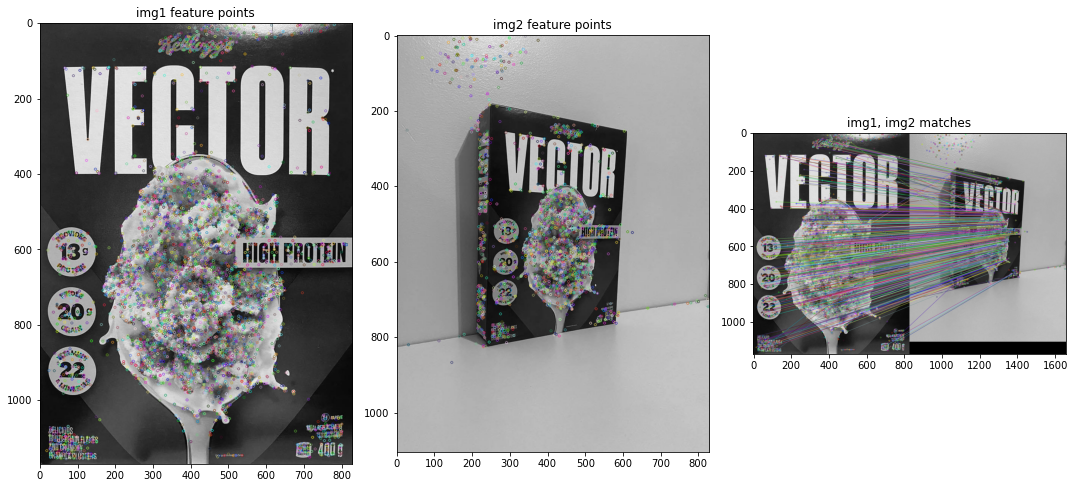

In [414]:

Matching(img1, img2, 1)

# 1.2

In [415]:
def AffineTransform(img, angle, scaling):
    outImg = []
    imgSize = (img.shape[1], img.shape[0]) #Note: inverse x and y in here 
    imgRefer = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    center_Refer = [int(imgSize[0] / 2), int(imgSize[1] / 2)]
    M_r = cv.getRotationMatrix2D(center_Refer, angle, scaling)
    imgTarget = cv.warpAffine(imgRefer, M_r, imgSize, borderValue = (0,0,0))



    kps, dess, matches = Matching(imgRefer, imgTarget, 0)

    #modify from lab, formatting data for estimateAffinePartial2D
    ref_pts = np.float32([kps[0][m[0].queryIdx].pt for m in matches]).reshape(-1,1,2)
    img_pts = np.float32([kps[1][m[0].trainIdx].pt for m in matches]).reshape(-1,1,2)

    M_a, _ = cv.estimateAffinePartial2D(ref_pts, img_pts)
    imgFinal = cv.warpAffine(img, M_a, imgSize, borderValue = (0,0,0))

    #plt to check
    outImg.append(imgRefer)
    outImg.append(imgTarget)
    outImg.append(imgFinal)
    PltImg(outImg, imgDescipt_2)



<Figure size 1800x1200 with 0 Axes>

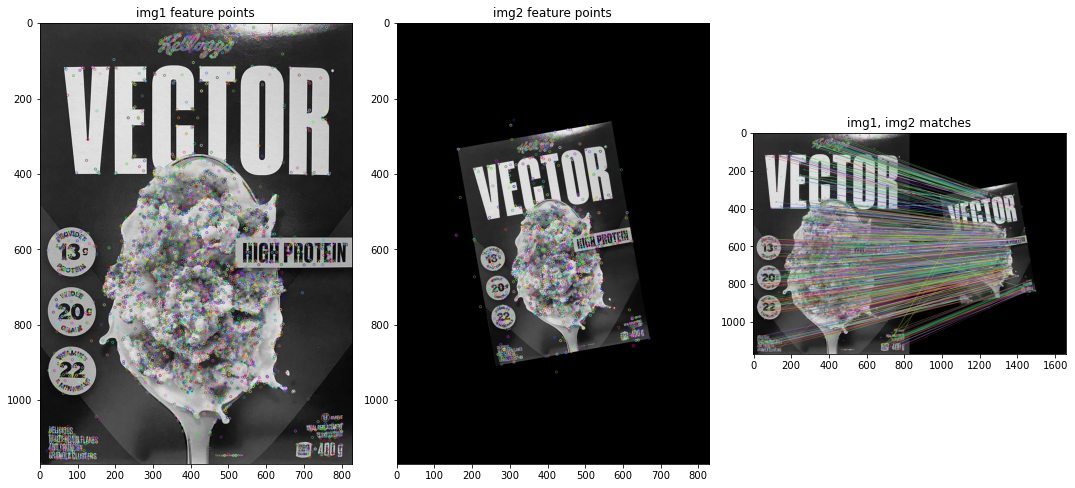

<Figure size 1800x1200 with 0 Axes>

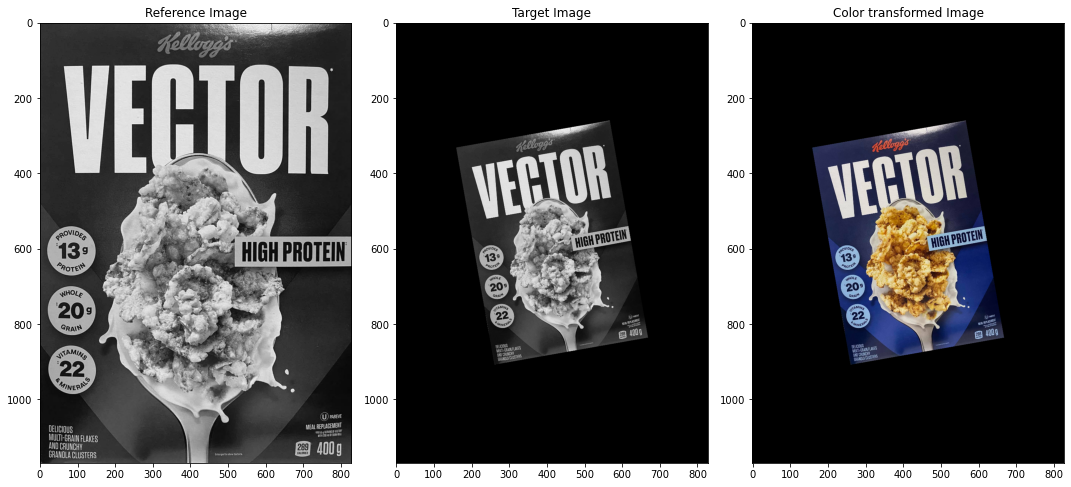

In [416]:
AffineTransform(img1, 10, 0.5)

# 1.3

In [417]:
def PerspectiveTransform(img1, img2):
    outImg = []
    img2Size = (img2.shape[1], img2.shape[0]) #Note: inverse x and y in here 

    img1Gray = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
    img2Gray = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)

    kps, dess, matches = Matching(img1Gray, img2Gray, flag = 0)

    #modify from lab, formatting data for estimateAffinePartial2D
    ref_pts = np.float32([kps[0][m[0].queryIdx].pt for m in matches]).reshape(-1,1,2)
    img_pts = np.float32([kps[1][m[0].trainIdx].pt for m in matches]).reshape(-1,1,2)

    M_p, _ = cv.findHomography(ref_pts, img_pts, method = cv.RANSAC) # Can be RANSAC or RHO or LMEDS
    imgFinal = cv.warpPerspective(img1, M_p, img2Size)
    temp = cv.cvtColor(img2Gray, cv.COLOR_GRAY2BGR)

    # #temp solution for replacement 
    # for x in range(img2Size[0]):
    #     for y in range(img2Size[1]):
    #         if imgFinal[y][x].all() == 0:
    #             imgFinal[y][x] = temp[y][x]
    
    # Second
    idx = np.where(imgFinal == 0)
    idx = set(list(zip(idx[0],idx[1])))
    for point in idx: 
        imgFinal[point] = temp[point]

    #plt to check
    outImg.append(img1Gray)
    outImg.append(img2Gray)
    outImg.append(imgFinal)
    PltImg(outImg, imgDescipt_2)

<Figure size 1800x1200 with 0 Axes>

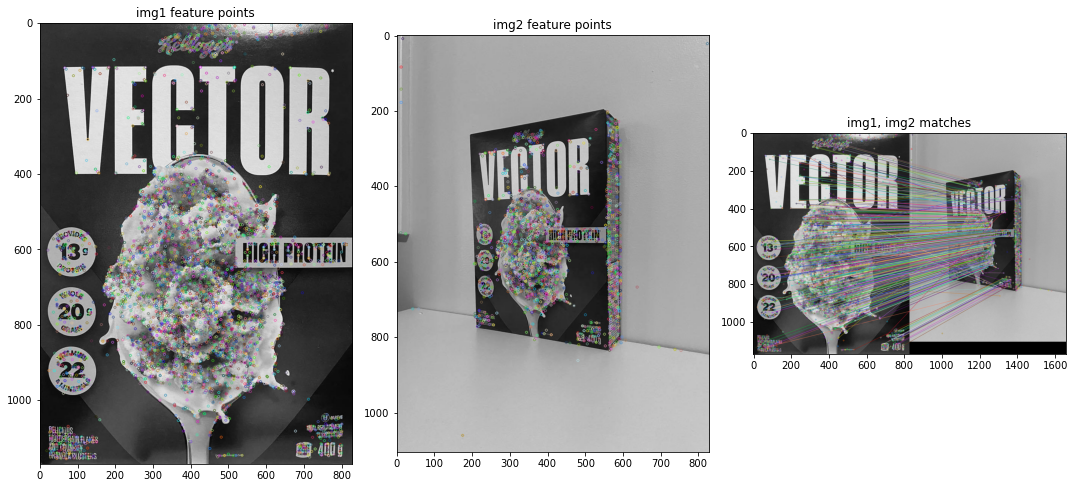

<Figure size 1800x1200 with 0 Axes>

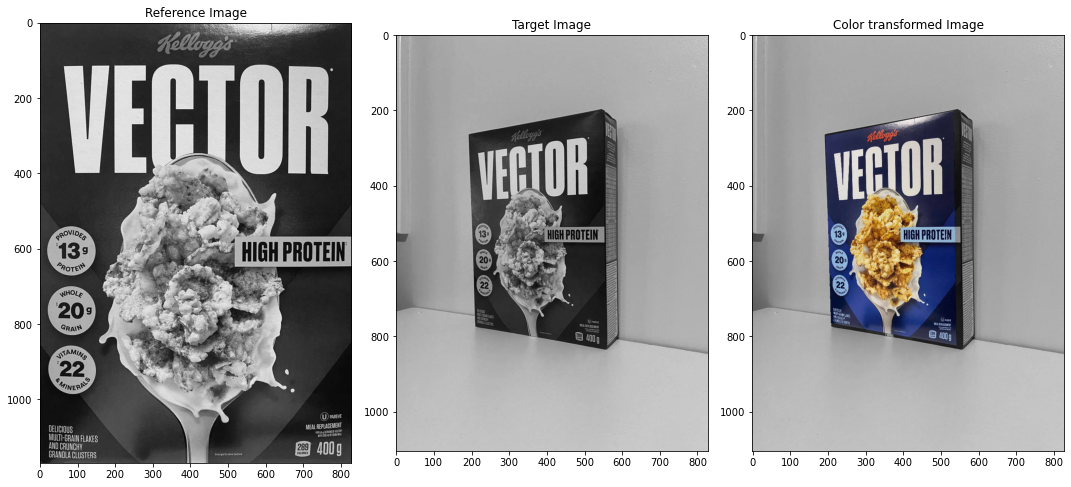

In [418]:
PerspectiveTransform(img1,img3)

<Figure size 1800x1200 with 0 Axes>

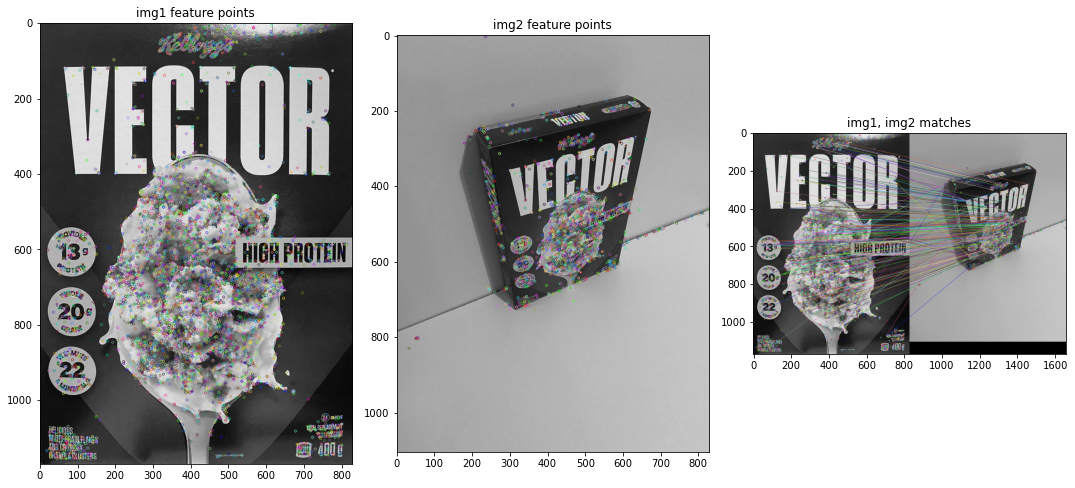

<Figure size 1800x1200 with 0 Axes>

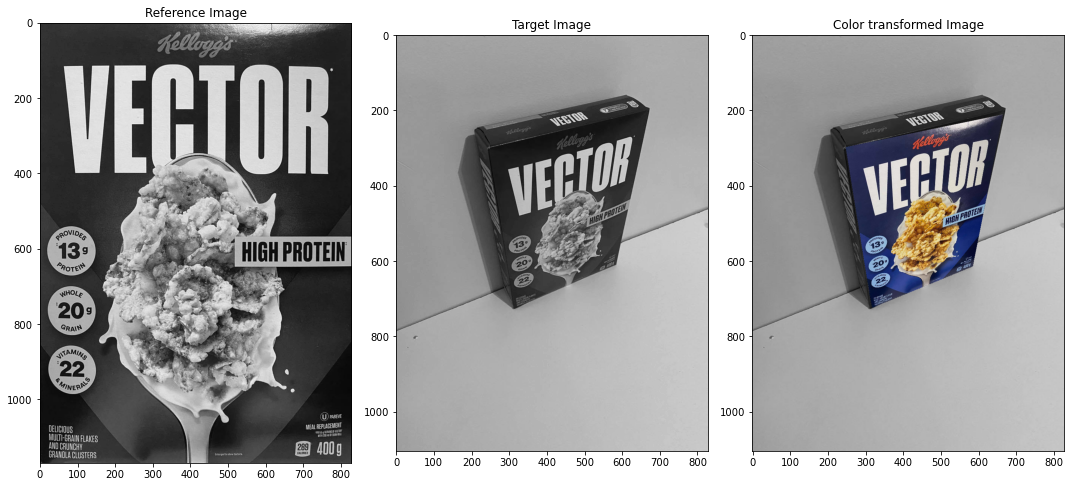

In [419]:
PerspectiveTransform(img1,img4)

<Figure size 1800x1200 with 0 Axes>

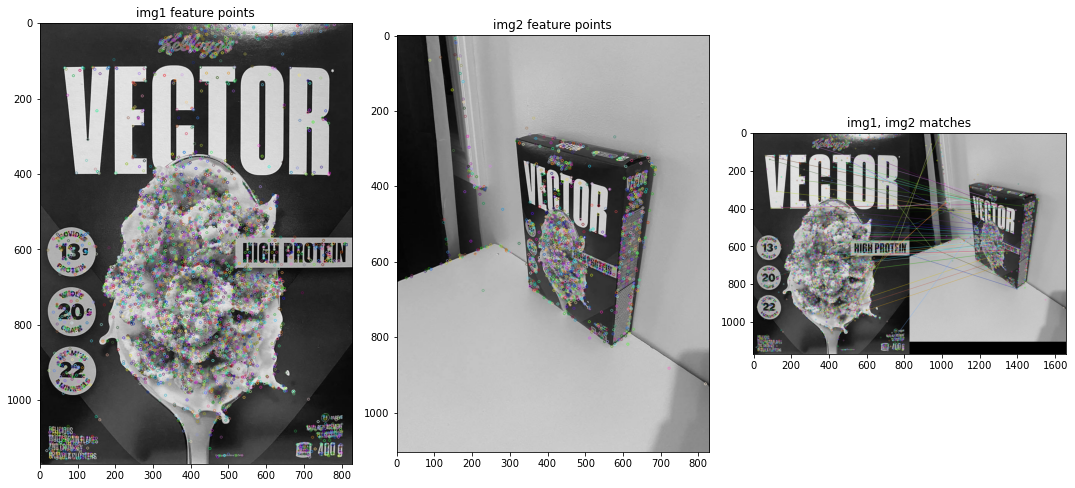

<Figure size 1800x1200 with 0 Axes>

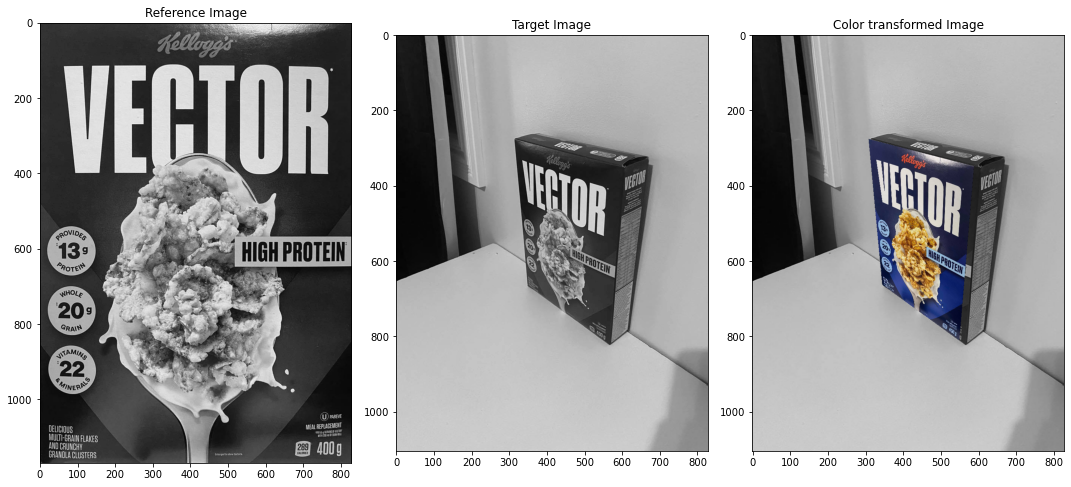

In [420]:
PerspectiveTransform(img1,img5)